### Imports

In [1]:
import os
import datetime
import logging
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr


import ocean_navigation_simulator
from ocean_navigation_simulator.environment.PlatformState import (
    PlatformState,
    SpatialPoint,
)
from ocean_navigation_simulator.reinforcement_learning.missions.MissionGenerator import (
    MissionGenerator,
)
from ocean_navigation_simulator.reinforcement_learning.missions.CachedNavigationProblem import (
    CachedNavigationProblem,
)

from ocean_navigation_simulator.reinforcement_learning.runners.GenerationRunner import (
    GenerationRunner,
)


from ocean_navigation_simulator.utils import units
from ocean_navigation_simulator.utils.misc import get_c3, set_arena_loggers

%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
c3 = get_c3()

Starting to connect to c3


# Set up the experiments

In [3]:
experiment_name = "safety_c3_debug_017"
exp = c3.Experiment.get(experiment_name)
# exp.remove()

In [4]:
exp

c3.Experiment(
 id='safety_c3_debug_017',
 meta=c3.Meta(
        tenantTagId=32,
        tenant='seaweed-control',
        tag='devseaweedrc1',
        created=datetime.datetime(2023, 2, 16, 22, 35, 13, tzinfo=datetime.timezone.utc),
        createdBy='doering@berkeley.edu',
        updated=datetime.datetime(2023, 2, 16, 22, 35, 13, tzinfo=datetime.timezone.utc),
        updatedBy='doering@berkeley.edu',
        timestamp=datetime.datetime(2023, 2, 16, 22, 35, 13, tzinfo=datetime.timezone.utc),
        fetchInclude='[]',
        fetchType='Experiment'),
 version=1,
 experimentName='safety_c3_debug_017',
 description='safety',
 arenaConfig={'bathymetry_dict': {'casadi_cache_settings': {'deg_around_x_t': 10},
                                   'field': 'Bathymetry',
                                   'source': 'gebco',
                                   'source_settings': {'filepath': 'ocean_navigation_simulator/package_data/bathymetry_and_garbage/bathymetry_global_res_0.083_0.083_max.nc

### Config

In [12]:
timeout_sim_h = 24 * 5
arena_config = {
    "casadi_cache_dict": {"deg_around_x_t": 2.0, "time_around_x_t": 432000},
    "platform_dict": {
        "battery_cap_in_wh": 400.0,
        "u_max_in_mps": 0.1,
        "motor_efficiency": 1.0,
        "solar_panel_size": 0.5,
        "solar_efficiency": 0.2,
        "drag_factor": 675.0,
        "dt_in_s": 600.0,
    },
    "use_geographic_coordinate_system": True,
    "spatial_boundary": None,
    "ocean_dict": {
        "region": "GOM",#"Region 1",
        "hindcast": {
            "field": "OceanCurrents",
            "source": "hindcast_files",
            "source_settings": {
                "folder": "data/miss_gen_hindcast/",
                "local": False,
                "source": "HYCOM",
                "type": "hindcast",
                "currents": "total",
            },
        },
        "forecast": None,
    },
    "bathymetry_dict": {
        "field": "Bathymetry",
        "source": "gebco",
        "source_settings": {
            "filepath": "ocean_navigation_simulator/package_data/bathymetry_and_garbage/bathymetry_global_res_0.083_0.083_max.nc"
        },
        "casadi_cache_settings": {"deg_around_x_t": 10},
        "use_geographic_coordinate_system": True,
    },
    "garbage_dict": {
        "field": "Garbage",
        "source": "Lebreton",
        "source_settings": {
            "filepath": "ocean_navigation_simulator/package_data/bathymetry_and_garbage/garbage_patch_global_res_0.083_0.083.nc"
        },
        "casadi_cache_settings": {"deg_around_x_t": 10},
        "use_geographic_coordinate_system": True,
    },
    "solar_dict": {"hindcast": None, "forecast": None},
    "seaweed_dict": {"hindcast": None, "forecast": None},
}
config = {
    ##### Target Sampling #####
    # HYCOM HC: lon [-98.0,-76.4000244140625], lat[18.1200008392334,31.92000007629394]
    # Copernicus FC: lon: [-98.0, -76.416664], lat: [18.083334, 30.0]
    # Combined: [-98.0, -76.416664], [18.1200008392334, 30.0]
    # GOM
    "x_range":[-98.0, -76.416664], 
    "y_range":[18.1200008392334, 30.0],
    # Region 1
    # "x_range": [-159, -106],
    # "y_range": [16, 39],
    # "x_range": [-160, -105],
    # "y_range": [15, 40],
    "t_range": [  # ['2022-08-01T00:00:00+00:00', '2022-08-30T00:00:00+00:00'],
        # Copernicus FC: 2022-04 until today, HYCOM Hindcast: 2021-09 until today
        datetime.datetime(year=2022, month=8, day=16, tzinfo=datetime.timezone.utc),
        datetime.datetime(year=2022, month=8, day=30, tzinfo=datetime.timezone.utc),
    ],
    "problem_timeout_in_h": timeout_sim_h,  # to be considered as feasible
    "problem_target_radius": 0.1,
    ##### HJ Planner #####
    "hj_specific_settings": {
        # 'grid_res' has to be smaller than target_radius to prevent hj_solver errors
        "grid_res": 0.02,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
        "direction": "multi-time-reach-back",
        "n_time_vector": 199,  # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
        "accuracy": "high",
        "artificial_dissipation_scheme": "local_local",
        "run_without_x_T": True,
        "progress_bar": False,
        "T_goal_in_seconds": 3600 * timeout_sim_h,  # 7 days here #
    },
    "hj_planner_box": 2.0,
    ##### Start Sampling #####
    "feasible_missions_per_target": 2,
    "feasible_mission_time_in_h": [80, 110],
    "random_missions_per_target": 0,
    "random_min_distance_from_target": 0.5,
    "min_distance_from_hj_frame": 0.5,
    "min_distance_from_land": 0.2,
    "random_min_distance_from_target": 0.5,
    # Safety specific values
    "max_distance_from_land": 3,
    "min_distance_from_garbage": 0.01,
    "max_distance_from_garbage": 1,
    ##### Actions #####
    "plot_batch": False,
    "animate_batch": False,
    "cache_forecast": False,
    "cache_hindcast": False,
    ##### Distance maps #####
    "filepath_distance_map": {
        "bathymetry": "ocean_navigation_simulator/package_data/bathymetry_and_garbage/bathymetry_distance_res_0.083_0.083_max_elevation_-150.nc",
        "garbage": "ocean_navigation_simulator/package_data/bathymetry_and_garbage/garbage_patch_distance_res_0.083_0.083_max.nc",
    },
}
objectiveConfig = {"type": "nav"}

### Create Experiment

Make sure you really want to create a new experiment and you ran `exp = c3.Experiment.get(experiment_name)` before '


In [7]:
# create Experiment
exp = c3.Experiment.createNew(
    name=experiment_name,
    description="safety",
    arenaConfig=arena_config,
    objectiveConfig=objectiveConfig,
    timeout_in_sec=3600 * timeout_sim_h,
)

In [8]:
exp = exp.get("experimentName")

# name.experimentName = "test_matthias"
# name.merge()
exp

c3.Experiment(
 id='safety_c3_debug_017',
 meta=c3.Meta(
        fetchInclude='[experimentName,id,version]',
        fetchType='Experiment'),
 version=1,
 experimentName='safety_c3_debug_017',
 T_horizon_FC_Error_Calculation_in_h=96)

# Set up generate batch job

## Set up and run mission generation

In [9]:
options = c3.GenMissionBatchJobOptionsAndreas(
    **{
        "experiment": exp,
        "missGenBatchConfig": config,
        "base_seed": 1,
        "nBatches": 2,  # each nBatch runs nMissionsGenPerBatch
        "nMissionGenPerBatch": 4,  # nb workers on which we loop,
        'hardwareProfileId': "appc8m64-w" #'appc72m660-w', #"appc8m642-w" #"appc72m660-w" appc8m64-w
    }
)
# total amount of missions: feasible_mission_per_target*nBatches*nMIssionGenPerBatch

#### [Debug locally]


In case you want to debug the Gen Mission c3 stuff locally. Just copy the according code from `GenMissionBatchJob.py`


In [10]:
batch = c3.GenMissionBatchJobBatchAndreas(**{"batch_seed": 1})
options = options

In [11]:

# Set up file paths and download folders
temp_folder = "/tmp/" + str(batch.batch_seed) + "/"
# create the folder if it doesn't exist yet
if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)
log_file_name = str(batch.batch_seed) + ".log"
logging.basicConfig(filename=temp_folder + log_file_name, level=logging.INFO)#, force=True

# change to this if basic setup works test
set_arena_loggers(logging.INFO)
logging.getLogger("MissionGenerator").setLevel(logging.DEBUG)


In [12]:

# get configs for mission generation
arena_config = options.experiment.get("arenaConfig").arenaConfig
# create the MissionGenerator Config
config = options.missGenBatchConfig

# Lots of replacement
filepath = ocean_navigation_simulator.__file__
module_path = os.path.dirname(filepath)

if "filepath_distance_map" in config and config["filepath_distance_map"] is not None:
    for key in config["filepath_distance_map"]:
        config["filepath_distance_map"][key] =  module_path + config["filepath_distance_map"][key].split("ocean_navigation_simulator")[-1]

data_dicts = ["bathymetry_dict", "garbage_dict"]
for d in data_dicts:
    if d in arena_config and arena_config[d] is not None:
        arena_config[d]["source_settings"]["filepath"]= module_path + arena_config[d]["source_settings"]["filepath"].split("ocean_navigation_simulator")[-1]


if "obstacle_dict" in config and config["obstacle_dict"] is not None:
    config["obstacle_dict"]["path_to_obstacle_file"] = module_path + config["obstacle_dict"]["path_to_obstacle_file"].split("ocean_navigation_simulator")[-1]

config_to_add = {
    "scenario_config": arena_config,
    "problem_timeout": datetime.timedelta(
        seconds=options.experiment.get("timeout_in_sec").timeout_in_sec
    ),
    "T_goal_in_seconds": options.experiment.get("timeout_in_sec").timeout_in_sec,
}

config = config | config_to_add

In [13]:
config

{'x_range': [-98.0, -76.416664],
 'y_range': [18.1200008392334, 30.0],
 't_range': [datetime.datetime(2022, 8, 16, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(2022, 8, 30, 0, 0, tzinfo=datetime.timezone.utc)],
 'problem_timeout_in_h': 120,
 'problem_target_radius': 0.1,
 'hj_specific_settings': {'grid_res': 0.02,
  'direction': 'multi-time-reach-back',
  'n_time_vector': 199,
  'accuracy': 'high',
  'artificial_dissipation_scheme': 'local_local',
  'run_without_x_T': True,
  'progress_bar': False,
  'T_goal_in_seconds': 432000},
 'hj_planner_box': 2.0,
 'feasible_missions_per_target': 2,
 'feasible_mission_time_in_h': [80, 110],
 'random_missions_per_target': 0,
 'random_min_distance_from_target': 0.5,
 'min_distance_from_hj_frame': 0.5,
 'min_distance_from_land': 0.2,
 'max_distance_from_land': 3,
 'min_distance_from_garbage': 0.01,
 'max_distance_from_garbage': 1,
 'plot_batch': False,
 'animate_batch': False,
 'cache_forecast': False,
 'cache_hindcast': False,
 'filepat

In [14]:
results_folder = "/tmp/missions/"
os.makedirs(results_folder, exist_ok=True)
# seed all of them
random.seed(batch.batch_seed)
all_problems = []
for worker in range(options.nMissionGenPerBatch):
    mission_generator = MissionGenerator(
        config=config
        | {
            "seed": int(random.uniform(0, 1000000)),
            "cache_folder": results_folder + str(worker) + "_",
        },
        c3=c3,
    )
    problems, _, _ = mission_generator.cache_batch()
    all_problems.extend(problems)

# Now upload all of them to the mission database!
exp = options.experiment
for idx, problem in enumerate(all_problems):
    try:
        exp.addMission(
            missionConfig=problem.to_c3_mission_config(),
            name="batch_seed_" + str(batch.batch_seed) + "_" + str(idx),
        )
    except BaseException:
        continue

INFO:arena.factory:Downloading 7 files to 'data/miss_gen_hindcast/'.
100%|██████████| 7/7 [00:03<00:00,  1.94it/s]
INFO:arena.factory:Download Hindcast Files: 2022-08-21 18-43-22 until 2022-08-27 20-43-22 (3.65s)
INFO:arena.ocean_field:DataField: Create Hindcast Source (0.2s)
INFO:arena.ocean_field:DataField: Forecast is the same as Hindcast for OceanCurrents.
INFO:arena:Arena: Generate Sources (0.2s)
INFO:arena:Arena: Generate Platform (0.0s)
INFO:arena.factory:ArenaFactory: Creating Arena for None (3.84s)
INFO:arena.platform:Platform: Set Dynamics F_x_next Function (0.0s)
INFO:arena.platform:Platform: Update Casadi + Dynamics (4.8s)
INFO:arena.factory:Downloading 7 files to 'data/miss_gen_hindcast/'.
  0%|          | 0/7 [00:00<?, ?it/s]INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-24T00:00:00Z-2022-08-24T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-25T00:00:00Z-2022-08-25T23:00:00Z.nc', 0.8M

In [ ]:
!cat /tmp/1/1.log

In [ ]:
#rm -rf miss_gen_hindcast/

In [15]:
all_problems

[Problem [start: [-79.11°,29.12°,2022-08-23 03:37:35], end: [-79.39°,28.93°], target_radius: 0.10, ttr: 91h] (INone, GNone BNone FI0),
 Problem [start: [-78.71°,27.96°,2022-08-23 03:37:35], end: [-79.39°,28.93°], target_radius: 0.10, ttr: 109h] (INone, GNone BNone FI1),
 Problem [start: [-82.42°,23.99°,2022-08-24 12:24:03], end: [-81.01°,24.21°], target_radius: 0.10, ttr: 107h] (INone, GNone BNone FI0),
 Problem [start: [-82.09°,23.47°,2022-08-24 12:24:03], end: [-81.01°,24.21°], target_radius: 0.10, ttr: 116h] (INone, GNone BNone FI1),
 Problem [start: [-77.53°,19.52°,2022-08-16 22:03:44], end: [-76.72°,18.95°], target_radius: 0.10, ttr: 106h] (INone, GNone BNone FI0),
 Problem [start: [-76.50°,18.90°,2022-08-16 22:03:44], end: [-76.72°,18.95°], target_radius: 0.10, ttr: 79h] (INone, GNone BNone FI1),
 Problem [start: [-80.13°,20.76°,2022-08-20 06:03:47], end: [-80.62°,20.66°], target_radius: 0.10, ttr: 82h] (INone, GNone BNone FI0),
 Problem [start: [-80.47°,21.79°,2022-08-20 06:03:4

In [16]:
# all_problems[0]
all_problems[0].extra_info

{'timeout_datetime': '2022-08-28T03:37:34+00:00',
 'start_target_distance_deg': 0.31162595652933806,
 'feasible': True,
 'ttr_in_h': 90.87691954241768,
 'random': False,
 'distance_to_shore_deg': 0.8796018202330168,
 'x_cache': [-81.3946818621808, -77.3946818621808],
 'y_cache': [26.928118606040407, 30.928118606040407],
 'factory_seed': 134364,
 'factory_index': 0}

### Start Jobs

In [18]:
gen_mission_job = c3.GenMissionBatchJobAndreas(**{"options": options.toJson()}).upsert()
# gen_mission_job = c3.GenMissionBatchJob(**{'options': options.toJson()}).upsert()
# gen_mission_job.setMaxConcurrency(12)
# gen_mission_job.setMaxConcurrencyPerNode(15)
gen_mission_job.start()
gen_mission_job

c3.GenMissionBatchJobAndreas(
 typeIdent='BATCHJ:O_AND_GENMISS_BATCH_JOB',
 id='2c8117dc-7d92-4a4c-b182-960c88de6f10',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 13, 21, 49, 44, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 13, 21, 49, 44, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 13, 21, 49, 44, tzinfo=datetime.timezone.utc)),
 version=1)

In [32]:
#gen_mission_job = c3.GenMissionBatchJobAndreas.get('17b2ad36-98b6-41d0-b3da-d966c0f10f2f')
gen_mission_job.status()

c3.BatchJobStatus(
 started=datetime.datetime(2023, 2, 13, 21, 49, 45, tzinfo=datetime.timezone.utc),
 startedby='doering@berkeley.edu',
 completed=datetime.datetime(2023, 2, 13, 21, 56, 13, tzinfo=datetime.timezone.utc),
 status='failed',
 errors=c3.Arry<JobRunErrorDetail>([c3.JobRunErrorDetail(
           failedActionId='4264.44895158',
           errorMsg='Error executing command: '
                     '/usr/local/share/c3/condaEnvs/seaweed-control/devseaweedrc1/py-ocean_sim_andreas/bin/python '
                     '/tmp/pythonActionSourceCache4013659452008430782/GenMissionBatchJobAndreas_processBatch.py\n'
                     'Process exited with 1 exit code.\n'
                     'No error message was received from the process',
           errorCodes='NotClassified',
           errorLog='c3.love.exceptions.C3RuntimeException: Error executing '
                     'command: '
                     '/usr/local/share/c3/condaEnvs/seaweed-control/devseaweedrc1/py-ocean_sim_andrea

In [29]:
gen_mission_job.computingActions()
# gen_mission_job.cancel()

c3.JobComputingActionsResult(
 actions=c3.Arry<ClusterAction>([c3.ClusterAction(
            id='4264.44895679',
            target='c3/c3/BatchQueue?action=dispatchCompute',
            tenant='c3',
            tag='c3',
            status='Running',
            child=c3.Action(
                    id='4264.44895715',
                    target='seaweed-control/devseaweedrc1/BatchQueue?action=compute',
                    tenant='seaweed-control',
                    tag='devseaweedrc1',
                    status='Running',
                    child=c3.Action(
                            id='4264.44895899',
                            target='seaweed-control/devseaweedrc1/GenMissionBatchJobAndreas?action=dispatchProcessBatch',
                            tenant='seaweed-control',
                            tag='devseaweedrc1',
                            status='Running',
                            child=c3.Action(
                                    id='4264.44897596',
           

In [ ]:
# Other Utils for the cluster
c3.Cluster.actionDump()

In [32]:
exp

c3.Experiment(
 id='safety_c3_debug_017',
 meta=c3.Meta(
        fetchInclude='[experimentName,id,version]',
        fetchType='Experiment'),
 version=1,
 experimentName='safety_c3_debug_017',
 T_horizon_FC_Error_Calculation_in_h=96)

In [31]:
len(exp.get("expMissions").expMissions)

TypeError: object of type 'NoneType' has no len()

In [ ]:
gen_mission_job = c3.GenMissionBatchJob.get('eb92b6ed-b529-4260-9efc-16c605b8b32c')
gen_mission_job.status()
#gen_mission_job.cancel() # to cancel the jobs


### Save and load missions from and to experiments instead of generating new ones


In [4]:
exp.get("expMissions").expMissions[0].get("missionConfig").missionConfig

{'x_0': [{'lon': -79.11446380615234,
   'lat': 29.120662689208984,
   'date_time': '2022-08-23T03:37:35+00:00'}],
 'x_T': {'lon': -79.3946818621808, 'lat': 28.928118606040407},
 'target_radius': 0.1,
 'seed': 134364,
 'feasible': True,
 'ttr_in_h': 90.87691954241768}


#### Experiment to take the missions from


In [5]:
problems = []
for miss in exp.get("expMissions").expMissions:
    missionConfig = miss.get("missionConfig").missionConfig
    problems.append(CachedNavigationProblem.from_c3_mission_config(missionConfig))

In [6]:
results_folder = f"{os.getcwd()}/"
df = pd.DataFrame([problem.to_dict() for problem in problems])
df["factory_index"] = 0
df.to_csv(results_folder + "problems.csv")

In [7]:
len(problems)

8


##### Make sure you create/select a new experiment where you want to add the retrieved missions to


In [8]:
exp
missionConfig = miss.get("missionConfig").missionConfig
missionConfig

{'x_0': [{'lon': -80.47073364257812,
   'lat': 21.79359245300293,
   'date_time': '2022-08-20T06:03:47+00:00'}],
 'x_T': {'lon': -80.62389853545635, 'lat': 20.661821171011795},
 'target_radius': 0.1,
 'seed': 255069,
 'feasible': True,
 'ttr_in_h': 90.07549625465859}

In [ ]:
# Some stuff in matthias notebook

In [22]:
for problem in problems:
    exp.addMission(problem.to_c3_mission_config())

AttributeError: 'float' object has no attribute 'tolist'

In [9]:
len(exp.get("expMissions").expMissions)

8

## Plot all of them on a map and get distribution information

NameError: name 'config' is not defined

/home/c3/.conda/envs/py-ocean_sim_andreas/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:531: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/c3/.conda/envs/py-ocean_sim_andreas/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:538: ShapelyDeprecationWarning:

__getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

<__array_function__ internals>:180: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/home/c3/.conda/envs/py-ocean_sim_andreas/lib/python3.9/site-packages/numpy/lib/function_base.py:5444: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shape

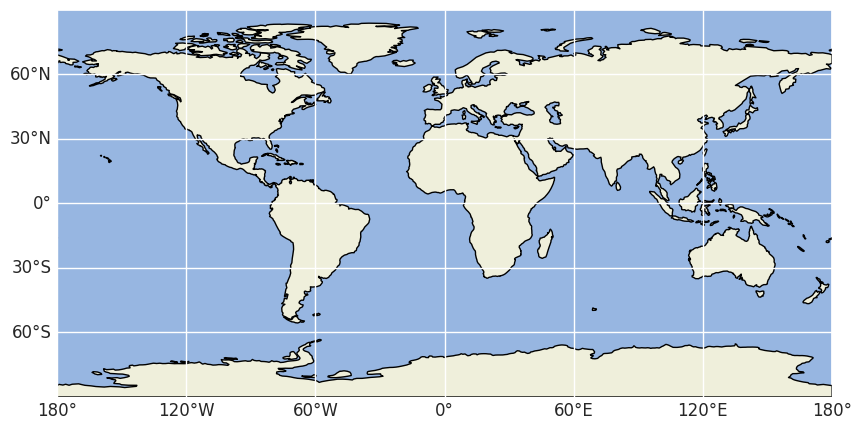

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_title("Time: " + datetime.fromtimestamp(time, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC'))

ax.add_feature(cfeature.LAND, zorder=3, edgecolor="black")
ax.add_feature(cfeature.OCEAN, zorder=0)
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.axis(xmin=config["x_range"][0], xmax=config["x_range"][1])
ax.axis(ymin=config["y_range"][0], ymax=config["y_range"][1])
# ax.axis(xmin=-160, xmax=-105)
#ax.axis(ymin=15, ymax=40)
# TODO: adapt Generation runner to use nice plotting
for miss_idx in range(len(df)):
    ax.scatter(
        df.iloc[miss_idx]["x_0_lon"],
        df.iloc[miss_idx]["x_0_lat"],
        c="red",
        marker="o",
        s=6,
        label="starts" if miss_idx == 0 else None,
    )
ax.scatter(df["x_T_lon"], df["x_T_lat"], c="green", marker="x", s=12, label="targets")
ax.legend()
# ax.get_figure().savefig(f"{analysis_folder}starts_and_targets.png")
ax.get_figure().show()

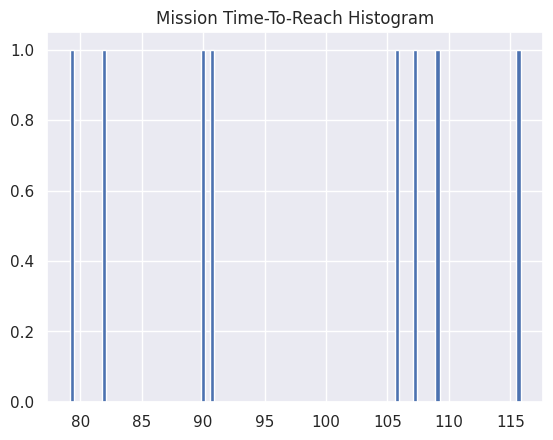

Starting to connect to c3


ValueError: keyfile does not exist

In [36]:
GenerationRunner.plot_ttr_histogram(results_folder)
GenerationRunner.plot_starts_and_targets(
    results_folder=results_folder,
    #pb_filename="problems.csv",
    scenario_config=arena_config,
)

#### Random utils

In [ ]:
status = " && status ==" + '"' + "running" + '"'
all_gen_mission_jobs = c3.GenMissionBatchJobAndreas.fetch(
    spec={
        "include": "[this]",
    }
).objs

In [ ]:
for job in all_gen_mission_jobs:
    if job.get("BatchJobStatus").status().status == "running":
        print(job.get("BatchJobStatus").status().status)
        # job.cancel()
        # print(job.get("BatchJobStatus").status().status)

# Add Observer

In [37]:
# Config for No observer
observer_config = {"observer": None}
# add observer
exp.addObserver(name="NoObserver", observerConfig=observer_config)

c3.ObserverSetting(
 id='safety_c3_debug_017_NoObserver',
 name='NoObserver',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 16, 23, 10, 14, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 16, 23, 10, 14, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 16, 23, 10, 14, tzinfo=datetime.timezone.utc)),
 version=1)

# Add Controller

In [38]:
# Controller Configs
HJMultiTimeConfig = {
    "replan_every_X_seconds": None,
    "replan_on_new_fmrc": True,
    "T_goal_in_seconds": 3600 * 24 * 6,  # 3d, 43200,     # 12h
    "accuracy": "high",
    "artificial_dissipation_scheme": "local_local",
    "ctrl_name": "ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner.HJReach2DPlanner",
    "d_max": 0.0,
    "deg_around_xt_xT_box": 1.5,
    "direction": "multi-time-reach-back",
    "grid_res": 0.02,
    "n_time_vector": 200,
    "progress_bar": True,
    "use_geographic_coordinate_system": True,
}
"""
StraightLineConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.NaiveController.NaiveController"
}
flockingConfig = {
    "unit": "km",
    "interaction_range": 9,  # km
    "grad_clip_range": 0.1,  # km
}
reactiveConfig = {
    "unit": "m",
    "mix_ttr_and_euclidean": False,
    "delta_3": 8800,  # collision threshold (communication - delta_3)
    "delta_2": 2000,  # safe zone threshold  ]communication - delta_2, communication - delta_3[
    "delta_1": 500,  # small threshold so that if distance > communication_thrsld- delta_1 we try to achieve connectivity
    "communication_thrsld": 9000,
    "k_1": 0.25,
    "k_2": 1,
}
"""

'\nStraightLineConfig = {\n    "ctrl_name": "ocean_navigation_simulator.controllers.NaiveController.NaiveController"\n}\nflockingConfig = {\n    "unit": "km",\n    "interaction_range": 9,  # km\n    "grad_clip_range": 0.1,  # km\n}\nreactiveConfig = {\n    "unit": "m",\n    "mix_ttr_and_euclidean": False,\n    "delta_3": 8800,  # collision threshold (communication - delta_3)\n    "delta_2": 2000,  # safe zone threshold  ]communication - delta_2, communication - delta_3[\n    "delta_1": 500,  # small threshold so that if distance > communication_thrsld- delta_1 we try to achieve connectivity\n    "communication_thrsld": 9000,\n    "k_1": 0.25,\n    "k_2": 1,\n}\n'

#### Add HJ Naive controller

In [39]:
#exp.experimentName = exp.get("experiment_name")
# add controller
exp.addController(name="hj_naive", ctrlConfig=HJMultiTimeConfig)

c3.ControllerSetting(
 id='safety_c3_debug_017_hj_naive',
 name='hj_naive',
 meta=c3.Meta(
        created=datetime.datetime(2023, 2, 16, 23, 13, 59, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 2, 16, 23, 13, 59, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 2, 16, 23, 13, 59, tzinfo=datetime.timezone.utc)),
 version=1)

#### Add Reactive Controller

#### Add Flocking Controller

# Set missions to ready to run

In [11]:
experiment = "experiment.id==" + '"' + exp.id + '"'
status = " && status==" + '"staged_for_feasibility"'
exp_list = c3.Mission.fetch(spec={"include": "[this]", "filter": experiment}).objs
print(len(exp_list))

8


In [41]:
for miss in exp_list:
    miss.status = "ready_to_run"
    miss.merge()

# Create Ocean Sim Runs

In [55]:
# Create the Run objects
exp.createOceanSimRuns(obs_name="NoObserver")#ctrl_name="safety"

True

## Run simulation debug 

In [13]:
exp_filter = "mission.experiment.id==" + '"' + exp.get("experimentName").experimentName + '"'
runs = c3.OceanSimRun.fetch(
    spec={"include": "[this]", "filter": exp_filter, "order": "ascending(mission.id)", "limit": -1}
).objs

In [14]:
run = runs[-1] # debug from nicolas
print(len(runs))
print(run)

8
c3.OceanSimRun(
 id='safety_c3_debug_017_batch_seed_1_7_hj_naive_NoObserver',
 meta=c3.Meta(
        tenantTagId=32,
        tenant='seaweed-control',
        tag='devseaweedrc1',
        created=datetime.datetime(2023, 2, 16, 23, 28, 32, tzinfo=datetime.timezone.utc),
        createdBy='doering@berkeley.edu',
        updated=datetime.datetime(2023, 2, 16, 23, 49, 48, tzinfo=datetime.timezone.utc),
        updatedBy='doering@berkeley.edu',
        timestamp=datetime.datetime(2023, 2, 16, 23, 49, 48, tzinfo=datetime.timezone.utc),
        fetchInclude='[]',
        fetchType='OceanSimRun'),
 version=2,
 mission=c3.Mission(id='safety_c3_debug_017_batch_seed_1_7'),
 controllerSetting=c3.ControllerSetting(id='safety_c3_debug_017_hj_naive'),
 observerSetting=c3.ObserverSetting(id='safety_c3_debug_017_NoObserver'),
 status='running_sim')


In [15]:
# ensure we have all necessary data to run
this = runs[-5].get(
    "mission.missionConfig, mission.experiment.timeout_in_sec,"
    + "mission.experiment.arenaConfig, mission.experiment.objectiveConfig,"
    + "controllerSetting.ctrlConfig, observerSetting.observerConfig"
)
this

c3.OceanSimRun(
 id='safety_c3_debug_017_batch_seed_1_3_hj_naive_NoObserver',
 meta=c3.Meta(
        fetchInclude='[{mission:[missionConfig,{experiment:[timeout_in_sec,arenaConfig,objectiveConfig,id]},id]},{controllerSetting:[ctrlConfig,id]},{observerSetting:[observerConfig,id]},id,version]',
        fetchType='OceanSimRun'),
 version=2,
 mission=c3.Mission(
           id='safety_c3_debug_017_batch_seed_1_3',
           experiment=c3.Experiment(
                        id='safety_c3_debug_017',
                        arenaConfig={'bathymetry_dict': {'casadi_cache_settings': {'deg_around_x_t': 10},
                                                          'field': 'Bathymetry',
                                                          'source': 'gebco',
                                                          'source_settings': {'filepath': 'ocean_navigation_simulator/package_data/bathymetry_and_garbage/bathymetry_global_res_0.083_0.083_max.nc'},
                                      

In [16]:
# update the entry while it's running
new_osr = c3.OceanSimRun(**{"id": this.id, "status": "running_sim"})
new_osr.merge()

c3.OceanSimRun(
 id='safety_c3_debug_017_batch_seed_1_3_hj_naive_NoObserver',
 meta=c3.Meta(
        tenantTagId=32,
        tenant='seaweed-control',
        tag='devseaweedrc1',
        created=datetime.datetime(2023, 2, 16, 23, 28, 32, tzinfo=datetime.timezone.utc),
        createdBy='doering@berkeley.edu',
        updated=datetime.datetime(2023, 2, 20, 20, 59, 5, tzinfo=datetime.timezone.utc),
        updatedBy='mariuswiggert@berkeley.edu',
        timestamp=datetime.datetime(2023, 2, 20, 20, 59, 5, tzinfo=datetime.timezone.utc),
        fetchInclude='[observerSetting,mission,meta,id,version,status,controllerSetting,{oceanSimResult:[log_file,trajectories,value_fct_file,reach_times_file,traj_currents_plot_file,traj_seaweed_plot_file,traj_currents_animation_file,traj_seaweed_animation_file,reachability_plot_file,distance_evol_plot_file,traj_network_animation_file]}]',
        fetchType='OceanSimRun'),
 version=2)

In [17]:
import os
import pickle
import logging
import datetime
import numpy as np
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import contextlib


import ocean_navigation_simulator
from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory
from ocean_navigation_simulator.problem_factories.Constructor import Constructor
from ocean_navigation_simulator.environment.PlatformState import SpatioTemporalPoint

@contextlib.contextmanager
def dummy_context_mgr():
    yield None

In [19]:
# set download directories (ignore set ones in arenaConfig)
arenaConfig = this.mission.experiment.arenaConfig
arenaConfig["timeout"] = this.mission.experiment.timeout_in_sec
to_download_forecast_files = False

### Prepare data for wandb ###
ctrlConfig = this.controllerSetting.ctrlConfig
missionConfig = this.mission.missionConfig
observerConfig = this.observerSetting.observerConfig

# Prepare variables for run naming
# Planning horizon in days
T_in_days = ctrlConfig["T_goal_in_seconds"] / (24 * 3600)
# Prepare string whether we use only HC or FC/HC
if arenaConfig["ocean_dict"]["forecast"] is not None:
    data_sources = "FC_HC"
else:
    data_sources = "HC"

# TODO: figure out running with/without obstacles
# if (
#     ctrlConfig["ctrl_name"]
#     == "ocean_navigation_simulator.controllers.hj_planners.HJBSeaweed2DPlanner.HJBSeaweed2DPlanner"
# ):
#     ctrl_name = "HJ"
# else:
#     ctrl_name = "undefined"

umax = arenaConfig["platform_dict"]["u_max_in_mps"]
deg_around_xt_xT_box = ctrlConfig["deg_around_xt_xT_box"]
grid_res = ctrlConfig["grid_res"]

# Log metrics in WandB
os.environ["WANDB_API_KEY"] = "8a97299607753ca36a26bec54e0c579f7bd180a4"
region = arenaConfig["ocean_dict"].get("region")

# TODO: rename ctrl name
ctrl_name = "HJ"
# TODO: rename project once it is not test anymore
wandb.init(
    # Set the project where this run will be logged
    project="OceanSafetyTest",
    entity="a-doering",
    id=this.id,
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"{ctrl_name}_{data_sources}_days_{T_in_days}_u_{umax}_deg_{deg_around_xt_xT_box}_res_{grid_res}_region_{region}_id_{this.id}",
    # Track hyperparameters and run metadata
    config={
        "missionConfig": missionConfig,
        "arenaConfig": arenaConfig,
        "ctrlConfig": ctrlConfig,
        "observerConfig": observerConfig,
        "mission.id": this.mission.id,
        "experiment.id": this.mission.experiment.id,
        # "path_to_local_data": user_param["metrics_dir"],
    },
)

##############################
# Set up file paths and download folders
# create strings for all files and external directories where to save results
temp_folder = "/tmp/" + this.id + "/"
# create the folder if it doesn't exist yet
if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)
log_file_name = this.id + ".log"
logging.basicConfig(
    filename=temp_folder + log_file_name, level=logging.DEBUG, force=True
)
traj_file_name = this.id + ".obj"
extDir = (
    "ocean_sim_run_results/"
    + this.mission.experiment.id
    + "/OceanSimRuns/"
    + this.id
)

# Safety path replacements
filepath = ocean_navigation_simulator.__file__
module_path = os.path.dirname(filepath)

if (
    "filepath_distance_map" in missionConfig
    and missionConfig["filepath_distance_map"] is not None
):
    for key in missionConfig["filepath_distance_map"]:
        missionConfig["filepath_distance_map"][key] = (
            module_path
            + missionConfig["filepath_distance_map"][key].split(
                "ocean_navigation_simulator"
            )[-1]
        )
data_dicts = ["bathymetry_dict", "garbage_dict"]
for d in data_dicts:
    if d in arenaConfig and arenaConfig[d] is not None:
        arenaConfig[d]["source_settings"]["filepath"] = (
            module_path
            + arenaConfig[d]["source_settings"]["filepath"].split(
                "ocean_navigation_simulator"
            )[-1]
        )
if (
    "obstacle_dict" in missionConfig
    and missionConfig["obstacle_dict"] is not None
):
    missionConfig["obstacle_dict"]["path_to_obstacle_file"] = (
        module_path
        + missionConfig["obstacle_dict"]["path_to_obstacle_file"].split(
            "ocean_navigation_simulator"
        )[-1]
    )

# for hindcast
arenaConfig["ocean_dict"]["hindcast"]["source_settings"]["folder"] = (
    "/tmp/" + this.id + "/hindcast_files/"
)
# For forecast
if arenaConfig["ocean_dict"]["forecast"] is not None:
    arenaConfig["ocean_dict"]["forecast"]["source_settings"]["folder"] = (
        "/tmp/" + this.id + "/forecast_files/"
    )
    to_download_forecast_files = (
        arenaConfig["ocean_dict"]["forecast"]["source"] == "forecast_files"
    )

# Prepping the file download
point_to_check = SpatioTemporalPoint.from_dict(
    this.mission.missionConfig["x_0"][0]
)
t_interval = [
    point_to_check.date_time,
    point_to_check.date_time
    + datetime.timedelta(
        seconds=this.mission.experiment.timeout_in_sec
        + arenaConfig["casadi_cache_dict"]["time_around_x_t"]
        + 7200
    ),
]
arena, controller = None, None

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: a-doering. Use `wandb login --relogin` to force relogin


1.png	  config	   MANIFEST.in				setup
2.png	  data		   ocean_navigation_simulator		setup.py
3.png	  generated_media  ocean_navigation_simulator.egg-info	tests
4.png	  LICENSE	   pyproject.toml			tmp
5.png	  logfile.log	   README.md				wandb
analysis  Makefile	   scripts


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]
100%|##########|  1.0000/1.0 [03:34<00:00, 214.05s/sim_s]
/home/andy/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning:

No contour levels were found within the data range.



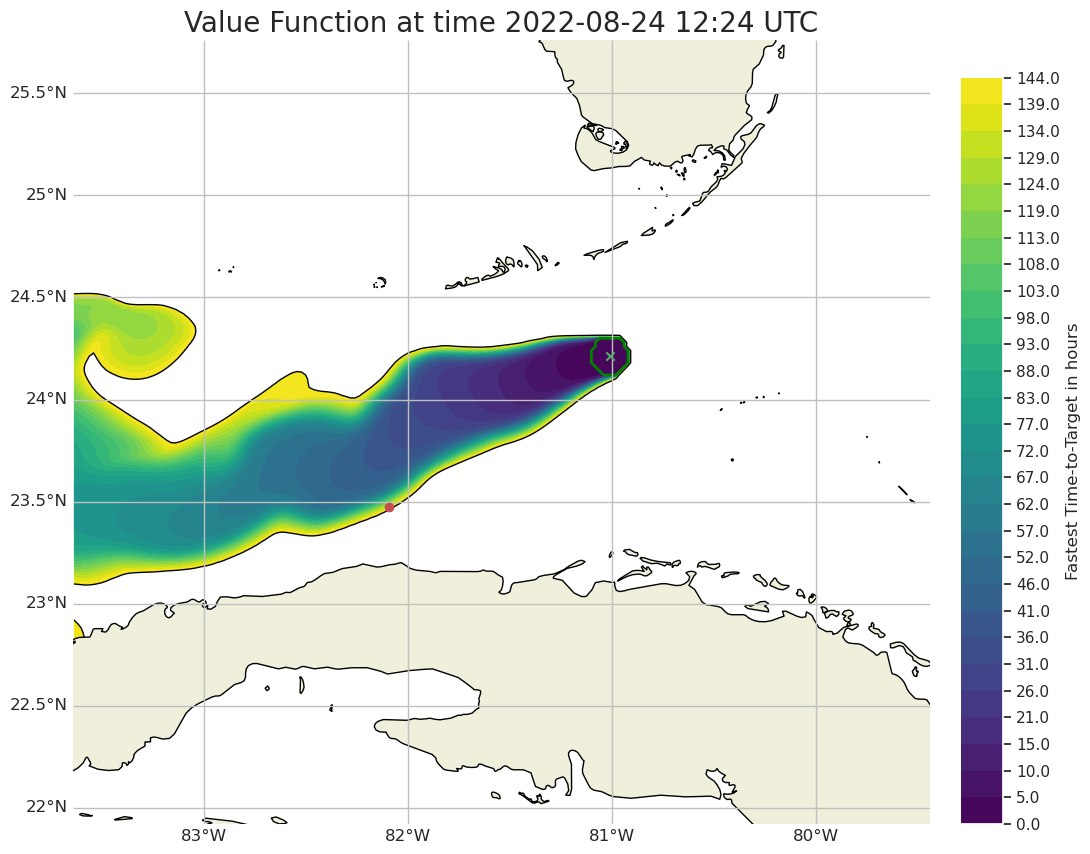

In [20]:
with (
    ArenaFactory.download_files(
        config=arenaConfig,
        type="hindcast",
        t_interval=t_interval,
        c3=c3,
        points=[point_to_check.to_spatial_point()],
    ) as download_hindcast_files_to_local,
    ArenaFactory.download_files(
        config=arenaConfig,
        type="forecast",
        t_interval=t_interval,
        c3=c3,
        points=[point_to_check.to_spatial_point()],
    )
    if to_download_forecast_files
    else dummy_context_mgr() as download_forecast_files_to_local,
):
    # Step 0: Create Constructor object which contains arena, problem, controller and observer
    constructor = Constructor(
        arena_conf=arenaConfig,
        mission_conf=this.mission.missionConfig,
        objective_conf=this.mission.experiment.objectiveConfig,
        ctrl_conf=this.controllerSetting.ctrlConfig,
        observer_conf=this.observerSetting.observerConfig,
    )
    # Step 1.1 Retrieve problem
    problem = constructor.problem

    # Step 1.2: Retrieve arena
    arena = constructor.arena
    observation = arena.reset(platform_state=problem.start_state)
    problem_status = arena.problem_status(problem=problem)

    # Step 2: Retrieve Controller
    controller = constructor.controller

    # Step 2.1
    # Log initial reachability snapshot as .jpg and .svg
    # need to call controller once before to init. before plot reachability
    controller.get_action(observation=observation)
    ax = controller.plot_reachability_snapshot(
        rel_time_in_seconds=0,
        granularity_in_h=5,
        alpha_color=1,
        time_to_reach=True,
        fig_size_inches=(12, 12),
        plot_in_h=True,
        return_ax=True,
    )
    fig = ax.get_figure()
    fig = plt.figure(fig)
    plt.savefig(temp_folder + "reachability_snapshot.svg")
    plt.savefig(temp_folder + "reachability_snapshot.jpg", dpi=80)

    # Step 3: Retrieve observer
    observer = constructor.observer
    observer.observe(observation)
    observation.forecast_data_source = observer

    # Step 4: Run Arena
    # Run while problem still open or in garbage
    while problem_status == 0 or problem_status == -4:
        # Get action
        action = controller.get_action(observation=observation)

        # execute action
        observation = arena.step(action)

        # TODO: collect data (e.g. distance to danger)
        # Observer data assimilation
        observer.observe(observation)
        observation.forecast_data_source = observer

        # update problem status
        problem_status = arena.problem_status(problem=problem)

    # TODO: figure out if state_trajectory is accessed correctly
    new_osr.status = "finished_running"
    new_osr.terminationReason = arena.problem_status_text(problem_status)
    if arena.problem_status_text(problem_status) == "Success":
        new_osr.T_arrival_time = (
            arena.state_trajectory[-1, 2] - arena.state_trajectory[0, 2]
        ) / 3600
    logged_error_message = None

In [21]:
# Step 4: create the OceanSimResult object with the files and upload it
if arena is not None:
    # Create a large dict with all trajectory data
    trajs_dict = {
        "sim_traj": arena.state_trajectory,
        "sim_ctrl": arena.action_trajectory,
        # "metrics": metrics_dict,
    }
    if controller is not None:
        if len(controller.planned_trajs) > 0:
            trajs_dict["plans"] = controller.planned_trajs
    with open(temp_folder + traj_file_name, "wb") as traj_file:
        pickle.dump(trajs_dict, traj_file)

    # Create value function and reach times
    value_fct_file_name = this.id + "_value_fct.obj"
    reach_times_file_name = this.id + "_reach_times.obj"

    with open(temp_folder + value_fct_file_name, "wb") as value_fct_file:
        pickle.dump(np.array(constructor.controller.all_values), value_fct_file)

    with open(temp_folder + reach_times_file_name, "wb") as reach_times_file:
        pickle.dump(
            np.array(constructor.controller.reach_times), reach_times_file
        )

    # Step 4.3 upload the traj_file_name together with the log_file_name to blob storage
    # Upload log file
    new_osr.oceanSimResult = c3.OceanSimResult()
    if os.path.exists(temp_folder + log_file_name):
        c3.Client.uploadLocalClientFiles(
            temp_folder + log_file_name,
            extDir + "/logs",
            {"peekForMetadata": True},
        )
        log_file = c3.File(
            **{"url": extDir + "/logs/" + log_file_name}
        ).readMetadata()
        new_osr.oceanSimResult.log_file = log_file
        os.remove(temp_folder + log_file_name)

    # Upload traj dict file
    if os.path.exists(temp_folder + traj_file_name):
        c3.Client.uploadLocalClientFiles(
            temp_folder + traj_file_name,
            extDir + "/trajs",
            {"peekForMetadata": True},
        )
        trajs_file = c3.File(
            **{"url": extDir + "/trajs/" + traj_file_name}
        ).readMetadata()
        new_osr.oceanSimResult.trajectories = trajs_file
        os.remove(temp_folder + traj_file_name)

    # log shortest distance to target
    if this.mission.experiment.objectiveConfig["type"] == "nav":
        new_osr.minDistanceToTarget = arena.final_distance_to_target(
            problem=problem
        )

In [59]:
# !ls /tmp/safety_c3_debug_017_batch_seed_1_6_hj_naive_NoObserver/
# #rm /tmp/safety_c3_debug_017_batch_seed_1_7_hj_naive_NoObserver/current_trajectory_on_map.svg
# temp_folder + "current_trajectory_on_map.svg"

reachability_snapshot.jpg
reachability_snapshot.svg
safety_c3_debug_017_batch_seed_1_6_hj_naive_NoObserver_reach_times.obj
safety_c3_debug_017_batch_seed_1_6_hj_naive_NoObserver_value_fct.obj


/home/andy/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning:


/home/andy/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/matplotlib/contour.py:1492: UserWarning:


/home/andy/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning:

No contour levels were found within the data range.



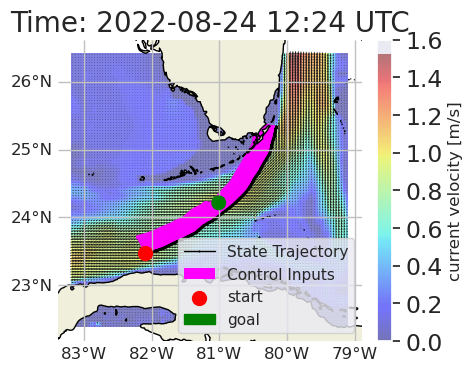

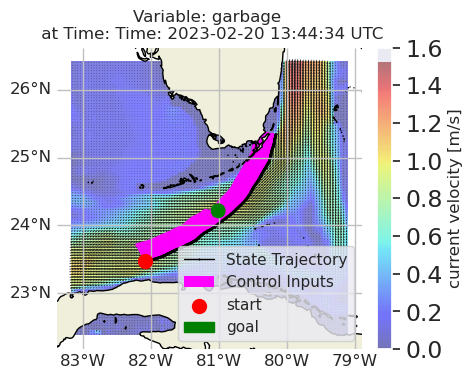

In [22]:
wandb.summary["termination_reason"] = arena.problem_status_text(problem_status)
# Log state_trajectory as table/dataframe
wandb.log(
    {"data_to_plot": wandb.Table(dataframe=arena.get_plot_data_for_wandb())},
    commit=False,
)
# Helps to debug to see if there are numerical errors that are global minima.
# Does not catch local minima resulting from numerical errors
wandb.summary["value_function_min"] = np.min(constructor.controller.all_values)
wandb.summary["garbage_sum"] = np.sum(arena.state_trajectory[:, 5], axis=0)
wandb.summary["garbage_average"] = np.mean(arena.state_trajectory[:, 5], axis=0)

# Log trajectory plot on currents as .jpg and .svg
ax = arena.plot_all_on_map(
    problem=problem, background="current", return_ax=True
)
fig = ax.get_figure()
fig = plt.figure(fig)
plt.savefig(temp_folder + "current_trajectory_on_map.svg")
plt.savefig(temp_folder + "current_trajectory_on_map.jpg", dpi=80)

# Log trajectory plot on garbage as .jpg and .svg
time_interval, lat_bnds, lon_bnds = arena.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
    x_0=problem.start_state.to_spatio_temporal_point(),
    x_T=problem.end_region,
    deg_around_x0_xT_box=1,
    temp_horizon_in_s=3600,
)
ax = arena.plot_all_on_map(
    problem=problem, background="currents", return_ax=True
)
ax = arena.garbage_source.plot_mask_from_xarray(
    xarray=arena.garbage_source.get_data_over_area(x_interval=lon_bnds, y_interval=lat_bnds),
    ax=ax,
)
fig = ax.get_figure()
fig = plt.figure(fig)
plt.savefig(temp_folder + "garbage_trajectory_on_map.svg")
plt.savefig(temp_folder + "garbage_trajectory_on_map.jpg", dpi=80)

# Log reachability we created before arena loop
image_reach = wandb.Image(
    temp_folder + "reachability_snapshot.jpg",
    caption="Initial reachability plot",
)
image_currents = wandb.Image(
    temp_folder + "current_trajectory_on_map.jpg",
    caption="Current trajectory on map",
)
image_garbage = wandb.Image(
    temp_folder + "garbage_trajectory_on_map.jpg",
    caption="Garbage trajectory on map",
)
wandb.log({"Reachability snapshot": image_reach}, commit=False)
wandb.log({"Current trajectory on map": image_currents}, commit=False)
wandb.log({"Garbage trajectory on map": image_garbage}, commit=True)
# log trajectory animations
arena.animate_trajectory(
    margin=0.25,
    problem=problem,
    temporal_resolution=3600,
    background="current",
    output=f"{temp_folder}platform_trajectories_currents.gif",
    fps=6,
)
arena.animate_trajectory(
    add_ax_func_ext=arena.add_ax_func_ext_overlay,
    margin=0.25,
    problem=problem,
    temporal_resolution=3600,
    output=f"{temp_folder}platform_trajectories_currents_overlay.gif",
    fps=6,
)

### Save files to c3 and add link to WandB
traj_currents_plot_file_name = "current_trajectory_on_map.svg"
traj_garbage_plot_file_name = "garbage_trajectory_on_map.svg"
reachability_plot_file_name = "reachability_snapshot.svg"
traj_currents_animation_file_name = "platform_trajectories_currents.gif"
traj_currents_animation_overlay_file_name = "platform_trajectories_currents_overlay.gif"


In [25]:
# Save files on c3/ Azure blob storage
# Add value function
c3.Client.uploadLocalClientFiles(
    temp_folder + value_fct_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
value_fct_file = c3.File(
    **{"url": extDir + "/logs/" + value_fct_file_name}
).readMetadata()
new_osr.oceanSimResult.value_fct_file = value_fct_file
os.remove(temp_folder + value_fct_file_name)

# Add reach times array
c3.Client.uploadLocalClientFiles(
    temp_folder + reach_times_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
reach_times_file = c3.File(
    **{"url": extDir + "/logs/" + reach_times_file_name}
).readMetadata()
new_osr.oceanSimResult.reach_times_file = reach_times_file
os.remove(temp_folder + reach_times_file_name)

# Add reachability_plot_file_name
c3.Client.uploadLocalClientFiles(
    temp_folder + reachability_plot_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
reachability_plot_file = c3.File(
    **{"url": extDir + "/logs/" + reachability_plot_file_name}
).readMetadata()
new_osr.oceanSimResult.reachability_plot_file = reachability_plot_file
os.remove(temp_folder + reachability_plot_file_name)

# Add traj_currents_plot_file_name
c3.Client.uploadLocalClientFiles(
    temp_folder + traj_currents_plot_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
traj_currents_plot_file = c3.File(
    **{"url": extDir + "/logs/" + traj_currents_plot_file_name}
).readMetadata()
new_osr.oceanSimResult.traj_currents_plot_file = traj_currents_plot_file
os.remove(temp_folder + traj_currents_plot_file_name)

# Add traj_garbage_plot_file_name
c3.Client.uploadLocalClientFiles(
    temp_folder + traj_garbage_plot_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
traj_garbage_plot_file = c3.File(
    **{"url": extDir + "/logs/" + traj_garbage_plot_file_name}
).readMetadata()
new_osr.oceanSimResult.traj_garbage_plot_file = traj_garbage_plot_file
os.remove(temp_folder + traj_garbage_plot_file_name)

# Add traj_currents_animation_file_name
c3.Client.uploadLocalClientFiles(
    temp_folder + traj_currents_animation_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
traj_currents_animation_file = c3.File(
    **{"url": extDir + "/logs/" + traj_currents_animation_file_name}
).readMetadata()
new_osr.oceanSimResult.traj_currents_animation_file = (
    traj_currents_animation_file
)
os.remove(temp_folder + traj_currents_animation_file_name)

# Add traj_currents_animation_overlay_file_name
c3.Client.uploadLocalClientFiles(
    temp_folder + traj_currents_animation_overlay_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
traj_currents_animation_overlay_file = c3.File(
    **{"url": extDir + "/logs/" + traj_currents_animation_overlay_file_name}
).readMetadata()
new_osr.oceanSimResult.traj_currents_animation_overlay_file = (
    traj_currents_animation_overlay_file
)
os.remove(temp_folder + traj_currents_animation_overlay_file_name)


# Log file urls (links to azure) to wandb summary
wandb.summary["value_fct_array"] = value_fct_file.generatePresignedUrl(
    "GET", "600d"
)
wandb.summary["reach_times_array"] = reach_times_file.generatePresignedUrl(
    "GET", "600d"
)
wandb.summary[
    "reachability_plot_svg"
] = reachability_plot_file.generatePresignedUrl("GET", "600d")
wandb.summary[
    "traj_current_plot_svg"
] = traj_currents_plot_file.generatePresignedUrl("GET", "600d")
wandb.summary[
    "traj_currents_animation"
] = traj_currents_animation_file.generatePresignedUrl("GET", "600d")

if os.path.exists(temp_folder + log_file_name):
    wandb.summary["log_file"] = log_file.generatePresignedUrl("GET", "600d")

In [50]:
!ls /tmp/safety_c3_debug_017_batch_seed_1_7_hj_naive_NoObserver/
!ls -al 
temp_folder


current_trajectory_on_map.jpg  reachability_snapshot.jpg
current_trajectory_on_map.svg


In [26]:
wandb.finish()

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/home/andy/miniconda3/envs/ocean_platform/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/andy/miniconda3/envs/ocean_platform/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/home/andy/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/home/andy/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/home/andy/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


garbage_average,0.0
garbage_sum,0.0
reach_times_array,https://devrconestor...
reachability_plot_svg,https://devrconestor...
termination_reason,Timeout
traj_current_plot_svg,https://devrconestor...
traj_currents_animation,https://devrconestor...
value_fct_array,https://devrconestor...
value_function_min,-1.00001


In [27]:
if new_osr.oceanSimResult is None:
    new_osr.oceanSimResult = c3.OceanSimResult(
        **{"error_message": logged_error_message}
    )
else:
    new_osr.oceanSimResult.error_message = logged_error_message

new_osr.merge()

c3.OceanSimRun(
 id='safety_c3_debug_017_batch_seed_1_3_hj_naive_NoObserver',
 version=3)

In [28]:
new_osr.oceanSimResult

c3.OceanSimResult(
 log_file=c3.AzureFile(
            contentLength=1027258,
            contentLocation='fs/seaweed-control/devseaweedrc1/ocean_sim_run_results/safety_c3_debug_017/OceanSimRuns/safety_c3_debug_017_batch_seed_1_3_hj_naive_NoObserver/logs/safety_c3_debug_017_batch_seed_1_3_hj_naive_NoObserver.log',
            contentType='application/json',
            eTag='"0x8DB138B642B4A33"',
            lastModified=datetime.datetime(2023, 2, 20, 21, 42, 40, tzinfo=datetime.timezone.utc),
            contentMD5='pf/B7K6cxYzG9JWzfBtbuw==',
            hasMetadata=True,
            url='azure://dev-rcone/fs/seaweed-control/devseaweedrc1/ocean_sim_run_results/safety_c3_debug_017/OceanSimRuns/safety_c3_debug_017_batch_seed_1_3_hj_naive_NoObserver/logs/safety_c3_debug_017_batch_seed_1_3_hj_naive_NoObserver.log',
            blobType='BLOCK_BLOB'),
 trajectories=c3.AzureFile(
                contentLength=54466,
                contentLocation='fs/seaweed-control/devseaweedrc1/ocean_sim

In [ ]:
ax = controller.plot_reachability_snapshot(
    rel_time_in_seconds=0,
    granularity_in_h=5,
    alpha_color=1,
    time_to_reach=True,
    fig_size_inches=(12, 12),
    plot_in_h=True,
    return_ax=True,
)

In [11]:
wandb.finish()

In [ ]:
ax = arena.plot_all_on_map(
    problem=problem,
    show_control_trajectory=False,
    return_ax=True,
)

In [ ]:
arena.animate_trajectory(
    margin=0.25,
    problem=problem,
    temporal_resolution=7200,
    background="current",
    output=f"{temp_folder}platform_trajectories.mp4",
    fps=10,
)

# Run Simulation

In [ ]:
# Create the Experiment Batch Job Options
options = c3.OceanSimRunBatchJobOptions(
    **{
        "experiment": exp,
        "actionRuntime": "andreas",  # enum('marius', 'andreas', 'matthias', 'nicolas')
    }
)

In [ ]:
# Start the Batch Job
run_job = c3.OceanSimRunBatchJob(**{"options": options.toJson()}).upsert()
# run_job.numAutoRecoveryAttempts = 1
run_job.start()
run_job

In [ ]:
# run_job = c3.OceanSimRunBatchJob.get('03b44bae-1a6e-4fa1-b07e-d906b48b84bf')
run_job.status()

In [ ]:
experiment = "mission.experiment.id==" + '"' + exp.id + '"'
objs_list = c3.OceanSimRun.fetch(spec={"include": "[this]", "filter": experiment}).objs
print("Total of {} OceanSimRuns".format(len(objs_list)))

staged_to_run = 0
running_sim = 0
finished_running = 0
run_failed = 0
for run in objs_list:
    if run.status == "staged_to_run":
        staged_to_run += 1
    elif run.status == "running_sim":
        running_sim += 1
    elif run.status == "finished_running":
        finished_running += 1
    elif run.status == "run_failed":
        run_failed += 1

print("staged_to_run: ", staged_to_run)
print("running_sim: ", running_sim)
print("finished_running: ", finished_running)
print("run_failed: ", run_failed)

In [ ]:
c3.Cluster.actionDump()

In [ ]:
exp_filter = "mission.experiment.id==" + '"' + exp.get("experimentName").experimentName + '"'
all_exp_runs = c3.OceanSimRun.fetch(
    spec={"include": "[this]", "filter": exp_filter, "order": "ascending(mission.id)", "limit": -1}
).objs

In [ ]:
all_exp_runs

In [ ]:
import pandas as pd


def get_results_df(this):
    # get all runs from the database (NOTE this can only get 2000 at a time!)
    exp_filter = "mission.experiment.id==" + '"' + this.get("experimentName").experimentName + '"'
    all_exp_runs = c3.OceanSimRun.fetch(
        spec={
            "include": "[this]",
            "filter": exp_filter,
            "order": "ascending(mission.id)",
            "limit": -1,
        }
    ).objs
    # get a list of all termination reasons
    termination_reason = []
    status = []
    arrival_time = []
    minDistanceToTarget = []
    ctrl_obs_name = []
    mission_ids = []

    for run in all_exp_runs:
        # get mission_id
        mission_ids.append(run.get("mission").mission.id)
        # get ctrl_obs setting
        ctrl_obs_name.append(
            run.get("controllerSetting.name").controllerSetting.name
            + "__"
            + run.get("observerSetting.name").observerSetting.name
        )
        # add outcomes
        termination_reason.append(run.terminationReason)
        status.append(run.status)
        arrival_time.append(run.T_arrival_time)
        minDistanceToTarget.append(run.minDistanceToTarget)

    # Make a df out of it
    df = pd.DataFrame(
        list(
            zip(
                mission_ids,
                ctrl_obs_name,
                status,
                termination_reason,
                arrival_time,
                minDistanceToTarget,
            )
        ),
        columns=[
            "mission_id",
            "setting",
            "status",
            "termination_reason",
            "arrival_time",
            "minDistance",
        ],
    )

    return df

In [ ]:
df = get_results_df(exp)

In [ ]:
df